###  Example of the coherence computation

In this notebook we use the autoregressive example model from [Dhamala et. al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.018701). The model consists of two coupled random variables ($2\rightarrow 1$), the coupling is time-varying therefore the coherence should detect the coupling dynamics. The model is given by the equations bellow:

$X_{1}(t) = 0.55X_{1}(t-1)-0.8X_{1}(t-2)+C(t)X_{2}(t-1)+\epsilon (t)$

$X_{2}(t) = 0.55X_{2}(t-1)-0.8X_{2}(t-2)+\xi (t)$

Here, $X_1(t)$ and $X_2(t)$ are $AR(2)$. The variable $t$ is the time step index,
such that the actual time is $t'=t\,\Delta t=t/f_{\rm s}$. Besides, we know by construction that
$X_2(t)$ influences $X_1(t)$ through the coupling constant $C$
(although the opposite does not happen). In the simulation $C(t)=0.25$ for $t<15$ s, and zero otherwise. 

In [1]:
import os

import itertools
import time
import numpy                 as     np
import xarray                as     xr
import matplotlib.pyplot     as     plt
import matplotlib
import plot
from   tqdm                   import tqdm
from   xfrites.conn.conn_spec import conn_spec

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()
bands = ['0-25Hz','25-50Hz', '50-75Hz','75-100Hz']

In [3]:
# Path to folder where to save figures
path_fig = "img/examples"

In [4]:
# Create directory to save figures
if not os.path.exists(path_fig):
    os.makedirs(path_fig)

#### Defining function to simulate de model

In [5]:
def ar_model_dhamala(N=5000, Trials = 10, Fs = 200, C=0.2, t_start=0, t_stop=None, cov = None):
    ''' 
        AR model from Dhamala et. al.
    '''
    
    T = N / Fs

    time = np.linspace(0, T, N)

    X = np.random.random([Trials, N]) 
    Y = np.random.random([Trials, N]) 

    def interval(t, t_start, t_stop):
        if t_stop==None:
            return (t>=t_start)
        else:
            return (t>=t_start)*(t<=t_stop)

    for i in tqdm( range(Trials) ):
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(N,))
        for t in range(2, N): 
            X[i,t] = 0.55*X[i,t-1] - 0.8*X[i,t-2] + interval(time[t],t_start,t_stop)*C*Y[i,t-1] + E[t,0]
            Y[i,t] = 0.55*Y[i,t-1] - 0.8*Y[i,t-2] + E[t,1]

    Z = np.zeros([Trials,2,N]) 

    Z[:,0,:] = X 
    Z[:,1,:] = Y 

    return Z

Model parameters

In [6]:
N  = 5000      # Number of observations
Fs = 200       # Sampling frequency
dt = 1.0 / Fs  # Time resolution
C  = 0.25      # Coupling parameter
Trials = 100   # Number of trials
freqs  = np.arange(1,100,1) # Frequency axis
# Covariance matrix
cov = np.array([ [1.00, 0.00],
                 [0.00, 1.00] ])

Generating data

In [7]:
# Generating data
X = ar_model_dhamala(N=N, Trials = Trials, C=C, Fs=Fs, t_start=0, t_stop=15, cov=cov)

100%|██████████| 100/100 [00:03<00:00, 32.38it/s]


In [8]:
X = xr.DataArray(X, dims=('trials', 'roi', 'times'),
                 coords=(np.arange(Trials), ['r0', 'r1'], np.arange(N) / Fs))

### Measuring coherence

To compute the coherence first the cross ($S_{12}(f,t)$), and auto-spectogram ($S_{11}(f,t)$ and $S_{22}(f,t)$) are computed. The coherence is defined as:

$C_{12}(f,t) = \frac{S_{12}S_{12}^{*}}{S_{11}S_{22}}$

However, for the equation above $C_{12}(f,t)=1$ $\forall \text{  } f, \text{ and } t$. Therefore, before taking the ratio in the equation above some temporal and frequency smoothing should be done. To do this, we convolve the auto- and cross-spectogram with a square window of size $w_f$, and $w_rt$, for the frequency and time axis, respectively.

Let's $g(w_t,w_f)$ be the filter, and $\tilde{g}(w_t,w_f)$ its representation in the frequency domain. We can then convolve each spectra with $g$, which gives:

$C_{12}(f,t) = \frac{\tilde{g}*(S_{12}S_{12}^{*})}{\tilde{g}*(S_{11})\tilde{g}*(S_{22})}$

Note that we ommit the dependencies on $f$ and $t$ for the spectra, and on $w_t$ and $w_f$ for the filter.

In [9]:
start = time.time()

# define temporal windows + compute the DFC
n_cycles = freqs/2.

kw = dict(
    freqs=freqs, times="times", roi=None, foi=None, n_jobs=-1,
    mode='morlet', n_cycles=n_cycles, decim=15, metric="coh", sm_kernel="square",
    sm_times=1.5, sm_freqs=1, block_size=1
)

# compute the coherence
coh = conn_spec(X, **kw)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

Elapsed time to load super-tensor: 5.886374235153198 sec.


Text(0.5, 1.0, 'Coherence')

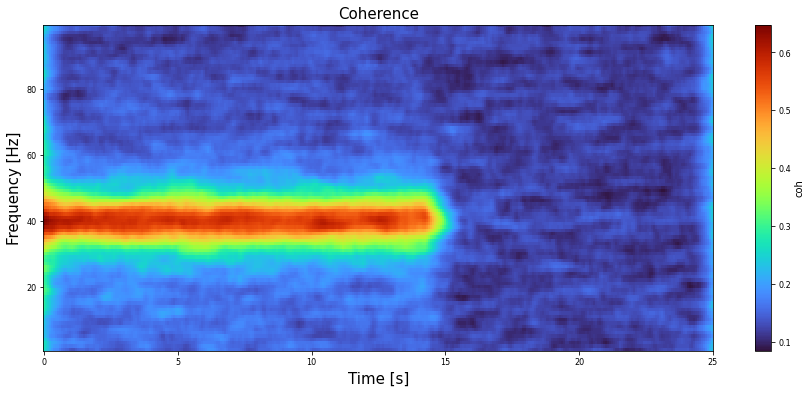

In [10]:
plt.figure(figsize=(15,6))
coh.isel(roi=0).mean("trials").plot.imshow(x="times", y="freqs", cmap="turbo")
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlabel('Time [s]', fontsize=15)
plt.title('Coherence', fontsize=15)

### Influence of the smoothing window in the estimation of the coherence

Next we analyse how the temporal and frequency smoothing influences the coherence computation. The other parameters such as down-sampling factor ($\Delta$) and number of cycles ($\lambda$) are maintained fixed: $\Delta = 15$ and $\lambda = f_c/2$, where $f_c$ are the center frequencies used.

One important thing to note is: what is the duration of the smoothing window in time?

If $f_s$ is the original sampling frequency of the signal, with a down-sampling factor of $\Delta$, and the time-smoothing window of $w_t$ is given in bins, its respective time-length is simply:

$w_t^{'} = w_t \Delta/f_s$

To demonstrate the influence of the dimensions of the filter $g$ in the coherence estimation we will use the combination of the following values for $w_t$ and $w_f$, respectively: $w_t=\{1, 10, 30, 70\}$, $w_t=\{1, 3, 5\}$. Notice that we use the values of $w_t$ and $w_f$ in bins but their respective length in time can be obtained using 
the equation above.

Below we show the results for the Morlet and Multitaper methods, respectively.

In [11]:
win_time = [.1, 0.5, 1.0, 2.0]
win_freq = [1, 3, 5]

In [12]:
def plot_coh(ax, wt, wf):
    
    plt.sca(ax)
    
    # define temporal windows + compute the DFC
    n_cycles = freqs / 2.

    kw = dict(
        freqs=freqs, times="times", roi=None, foi=None, n_jobs=-1,
        mode='morlet', n_cycles=n_cycles, decim=15, metric="coh",
        sm_times=wt, sm_freqs=wf, block_size=1
    )

    # compute the coherence
    coh = conn_spec(X, **kw)

    
    plt.imshow(coh.isel(roi=0).mean(dim="trials"), aspect="auto", cmap="viridis", origin="lower",
               extent=[coh.times[0], coh.times[-1], coh.freqs[0], coh.freqs[-1]], 
               vmin=0, vmax=1)
    
    del coh

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=1, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=7, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=13, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=27, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=1, sm_freqs=3)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=7, sm_freqs=3)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=13, sm_freqs=3)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=27, sm_freqs=3)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=1, sm_freqs=5)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=7, sm_freqs=5)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=13, sm_freqs=5)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=27, sm_freqs=5)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

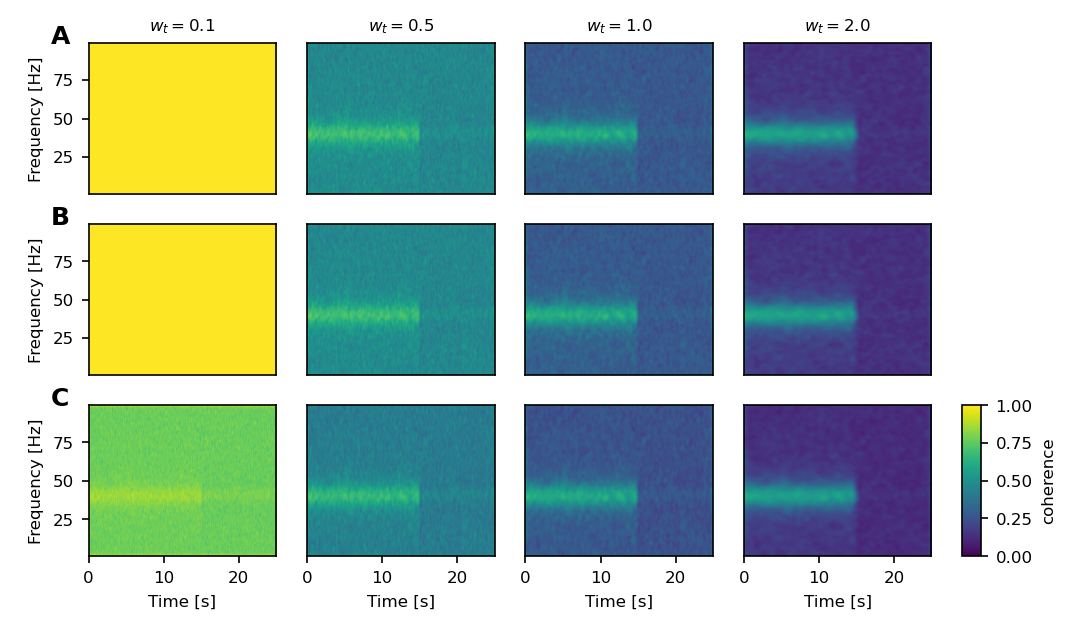

In [13]:
fig = plt.figure(figsize=(7., 3.8), dpi=150)

gs1 = fig.add_gridspec(nrows=len(win_freq), ncols=len(win_time)+1, width_ratios=(1,1,1,1,0.1), left=0.07, right=0.92, bottom=0.05, top=0.95)

# Panel A
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])
ax4 = plt.subplot(gs1[3])
ax5 = plt.subplot(gs1[4]) # bar
ax6 = plt.subplot(gs1[5])
ax7 = plt.subplot(gs1[6])
ax8 = plt.subplot(gs1[7])
ax9 = plt.subplot(gs1[8])
ax10 = plt.subplot(gs1[9]) # bar
ax11 = plt.subplot(gs1[10])
ax12 = plt.subplot(gs1[11])
ax13 = plt.subplot(gs1[12])
ax14 = plt.subplot(gs1[13])
ax15 = plt.subplot(gs1[14]) # bar

plt.sca(ax5)
plt.axis("off")
plt.sca(ax10)
plt.axis("off")

ax_list = fig.get_axes()
use     = np.array( [0,1,2,3,5,6,7,8,10,11,12,13] )
comb    = np.array(list(itertools.product(win_freq, win_time)))
_iter   = np.hstack((use[:,None],comb))

for count, wf, wt in _iter:
    plot_coh(ax_list[int(count)], wt, wf )
    if wf < 5: plt.xticks([])
    if wt > .1: plt.yticks([])
    if wf==1: plt.title(r"$w_t = $"+str(wt))
    if wt==.1: plt.ylabel("Frequency [Hz]", fontsize=SMALL_SIZE)
    if wf==5: plt.xlabel("Time [s]", fontsize=SMALL_SIZE)

bg = plot.Background(visible=False)

plot.add_panel_letters(fig, axes=[ax1, ax6, ax11], fontsize=12,
                       xpos=[-0.2]*3, ypos=[1.0]*3)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=matplotlib.cm.viridis, norm=norm), cax=ax15, extend=None, shrink=0.1)
cbar.ax.set_ylabel("coherence", rotation='vertical', fontsize=SMALL_SIZE)

plt.savefig(f"{path_fig}/win_smooth_dependence.png")

### Single-trial coherence estimation using Morlet method

In [14]:
kw['sm_times']     = 1.5
kw["foi"]          = foi   = np.array([
                                        [0.1, 25.],
                                        [25., 50.],
                                        [50., 75.],
                                        [75., 100.],
                                            ])
 
coh = conn_spec(X, **kw)

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

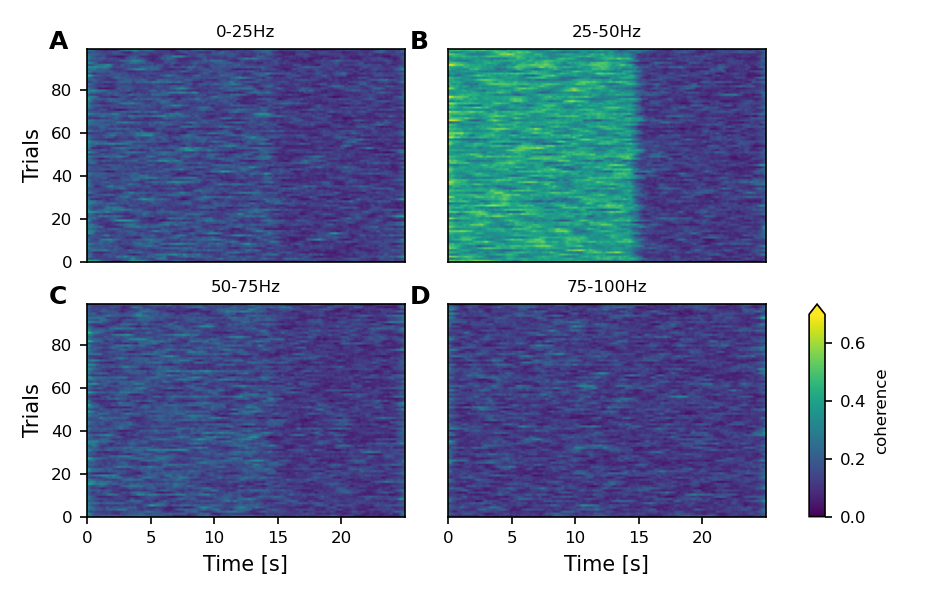

In [15]:
fig = plt.figure(figsize=(6., 3.8), dpi=150)

gs1 = fig.add_gridspec(nrows=2, ncols=3, width_ratios=(1,1,0.05), left=0.08, right=0.90, bottom=0.12, top=0.94)

# Panel A
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])
ax4 = plt.subplot(gs1[3])
ax5 = plt.subplot(gs1[4])
ax6 = plt.subplot(gs1[5])

plt.sca(ax3)
plt.axis("off")

plt.sca(ax1)
plt.imshow(coh.isel(roi=0,freqs=0), aspect="auto", cmap="viridis", origin="lower",
           extent=[coh.times[0], coh.times[-1], coh.trials[0], coh.trials[-1]], 
           vmin=0, vmax=.7)
plt.title(f"{bands[0]}")
plt.ylabel("Trials")
plt.xticks([])
plt.sca(ax2)
plt.imshow(coh.isel(roi=0,freqs=1), aspect="auto", cmap="viridis", origin="lower",
           extent=[coh.times[0], coh.times[-1], coh.trials[0], coh.trials[-1]], 
           vmin=0, vmax=.7)
plt.title(f"{bands[1]}")
plt.xticks([])
plt.yticks([])
plt.sca(ax4)
plt.imshow(coh.isel(roi=0,freqs=2), aspect="auto", cmap="viridis", origin="lower",
           extent=[coh.times[0], coh.times[-1], coh.trials[0], coh.trials[-1]], 
           vmin=0, vmax=.7)
plt.title(f"{bands[2]}")
plt.ylabel("Trials")
plt.xlabel("Time [s]")
plt.sca(ax5)
plt.imshow(coh.isel(roi=0,freqs=3), aspect="auto", cmap="viridis", origin="lower",
           extent=[coh.times[0], coh.times[-1], coh.trials[0], coh.trials[-1]], 
           vmin=0, vmax=.7)
plt.title(f"{bands[3]}")
plt.xlabel("Time [s]")
plt.yticks([])


norm = matplotlib.colors.Normalize(vmin=0, vmax=.7)
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=matplotlib.cm.viridis, norm=norm), cax=ax6, extend="max", shrink=0.1)
cbar.ax.set_ylabel("coherence", rotation='vertical', fontsize=SMALL_SIZE)

plot.add_panel_letters(fig, axes=[ax1, ax2, ax4, ax5], fontsize=12,
                       xpos=[-0.12, -0.12, -0.12, -0.12], ypos=[1.0, 1.0, 1.0, 1.0])

bg = plot.Background(visible=False)

plt.savefig(f"{path_fig}/single_trial_coh_model.png")

### Surrogates

In [16]:
import sys
import sys; sys.path.insert(1, '/home/vinicius/storage1/projects/brainhack_2021/signal')

In [17]:
from surrogates import trial_swap_surrogates

In [18]:
kw['sm_times']     = 1.5
kw["foi"]          = foi   = np.array([
                                        [0.1, 25.],
                                        [25., 50.],
                                        [50., 75.],
                                        [75., 100.],
                                            ])
 
coh = conn_spec(X, **kw)

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

In [23]:
def _surrogate_coh(n_surr,val):

    seeds = np.arange(n_surr, dtype=int) * 100
    
    coh = []
    for seed in tqdm( seeds ):
        X_rnd = trial_swap_surrogates(X,seed=seed,verbose=False)
        coh  += [conn_spec(X_rnd, **kw)]
    return xr.concat(coh, "seeds")

In [24]:
coh_surr = _surrogate_coh(10,1)

  0%|          | 0/10 [00:00<?, ?it/s]WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

 10%|█         | 1/10 [00:06<00:58,  6.48s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

 20%|██        | 2/10 [00:12<00:51,  6.49s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

 30%|███       | 3/10 [00:19<00:45,  6.56s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

 40%|████      | 4/10 [00:26<00:39,  6.52s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

 50%|█████     | 5/10 [00:32<00:32,  6.52s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

 60%|██████    | 6/10 [00:38<00:25,  6.45s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

 70%|███████   | 7/10 [00:45<00:19,  6.39s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

 80%|████████  | 8/10 [00:51<00:12,  6.38s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

 90%|█████████ | 9/10 [00:57<00:06,  6.38s/it]WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

100%|██████████| 10/10 [01:04<00:00,  6.44s/it]


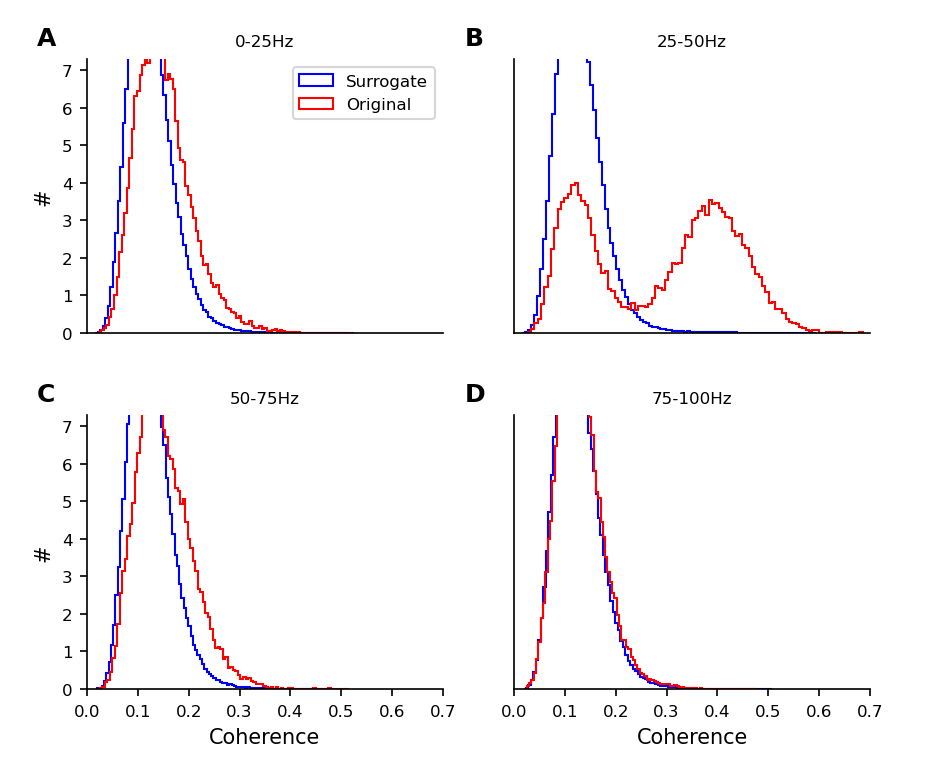

In [25]:
fig = plt.figure(figsize=(6., 5), dpi=150)

gs1 = fig.add_gridspec(nrows=2, ncols=2, left=0.08, right=0.95, bottom=0.1, top=0.94, hspace=0.3, wspace=.2)

# Panel A
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])
ax4 = plt.subplot(gs1[3])

ax_list = fig.get_axes()

for i in range(coh.sizes["freqs"]):
    plt.sca(ax_list[i])
    plt.hist(coh_surr.isel(freqs=i).values.flatten(), density=True,bins=100, label='Surrogate', histtype='step', fill=False, color='b');
    plt.hist(coh.isel(freqs=i).values.flatten(), density=True,bins=100, label='Original', histtype='step', fill=False, color='r');
    if i==0 or i==2: plt.ylabel('#')
    if i>1: plt.xlabel('Coherence')
    if i==1 or i==3: plt.yticks([])
    if i==0 or i==1: plt.xticks([])
    if i==0: plt.legend()
    plt.title(f'{bands[i]}')
    ax_list[i].spines['right'].set_visible(False)
    ax_list[i].spines['top'].set_visible(False)
    plt.ylim([0,7.3])
    plt.xlim([0,.7])

plot.add_panel_letters(fig, axes=[ax1, ax2, ax3, ax4], fontsize=12,
                       xpos=[-0.14, -0.14, -0.14, -0.14], ypos=[1.05, 1.05, 1.05, 1.05])

bg = plot.Background(visible=False)

plt.savefig(f"{path_fig}/surr_coh_model.png")

### Estimating coherence for broadbands using Multitaper method

To estimate the coherence (or spectra) in given bands we can use the multitaper method. Supose that we have the center frequencies of each band $f_c = \{f_{0},\dots, f_{n}\}$, where $n$ is the number of bands, and the bandwidth of each band $\delta f = \{\delta f_{0},\dots,\delta f_{n}\}$.

If $t_b$ is the time bandwidth of the Multitaper transform, the number of cycles can be computed by:

$n_\rm{cycles} = t_b\frac{f_c}{\delta f}$

This can be used to compute the spctra (and the coherence) directly in each band of interest.

For this example using the toy model, let's supose that:

$f_c = \{12.5, 37.5, 62.5, 87.5\}$, and

$\delta f = \{12.5, 12.5, 12.5, 12.5\}$
 
If we set $t_b = 8.0$, the number of cycles will be $n_\rm{cycles} = 8.0\frac{f_c}{12.5} =\{8, 24, 40, 56\}$

In [26]:
f_c = np.array([12.5,37.5,62.5,87.5])
d_f = 12.5
t_b = 4.0
n_cycles = t_b * f_c / d_f

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=4, decim=15, sm_times=1, sm_freqs=1)


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=4, decim=15, sm_times=7, sm_freqs=1)


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=4, decim=15, sm_times=13, sm_freqs=1)


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Computing pairwise Coherence (n_pairs=1, n_freqs=4, decim=15, sm_times=27, sm_freqs=1)


  0%|          | Estimating pairwise Coherence for trials 0...99 : 0/1 [00:00<?,       ?it/s]

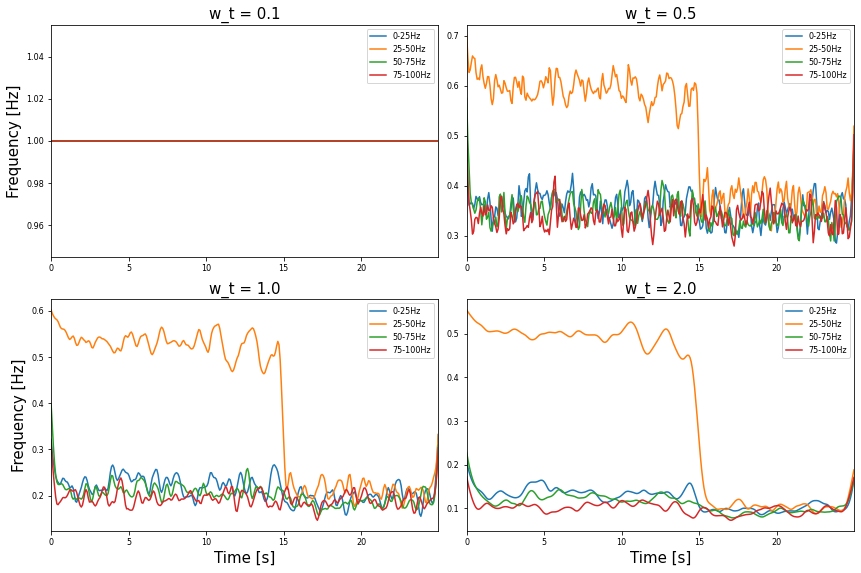

In [27]:
plt.figure(figsize=(12,8))
count = 1

for i in range(len(win_time)):

    kw = dict(
    freqs=f_c, times="times", roi=None, foi=None, n_jobs=1,
    mode='morlet', n_cycles=n_cycles, decim=15, metric="coh",
    sm_times=win_time[i], sm_freqs=1, block_size=1
    )
    
    coh = conn_spec(X, **kw)

    plt.subplot(2,2,count)
    for b in range(len(f_c)):
        plt.plot(coh.times, coh.isel(roi=0).mean(dim='trials')[b,:], label = bands[b])
        if i%2==0: plt.ylabel('Frequency [Hz]', fontsize=15)
        if i==2 or i==3: plt.xlabel('Time [s]', fontsize=15)
        plt.title('w_t = ' + str(win_time[i]), fontsize=15)
        plt.legend()
        plt.xlim(coh.times[0],coh.times[-1])
    count += 1
plt.tight_layout()

As expected using $w_f>1$ is not good because it averages over bands creating artificial peaks. And big values of $w_t$ results in poor temporal resolution of events, for instance for $w_t=70$ the moment when the coupling between $X_1(t)$ and $X_2(t)$ is turned off is not well located in time.